# THIS IS THE SOLUTION FOR COMPUTATIONAL INTELLIGENS LAB 01

> Author: `Daniel Bologna - s310582`
> - You can find the solution below.

Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [2312]:
from random import random, seed
from itertools import product
import numpy as np

from icecream import ic

# EXTRA LIBRARIES (!plot ONLY purpose!)
from matplotlib import pyplot as plt
from itertools import accumulate

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2313]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [2314]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [2315]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [2316]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4279247.186158977))

In [2317]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(2141430.8385639535))

---

# Solution

## Implementation

### Utility functions

In [2318]:
def clamp(_min, _max, _val):
    return max(_min, min(_max, _val))

### Fitness function

See the fitness as the tuple containing the following values

- valid(solution)
- union of chosen universe's elements
- -cost(solution)

> Our objective is to maximize the number of elements in the universe covered by our subsets, and minimize -cost.

In [2319]:
def fitness(_current_solution : np.ndarray) -> tuple[bool, float, float]:
    return (
        valid(_current_solution), 
        np.logical_or.reduce(SETS[_current_solution]).sum(), 
        -cost(_current_solution))

### Tweak function

In [2320]:
def tweak(_current_solution : np.ndarray, step_size : float) -> np.ndarray:
    new_solution = _current_solution.copy()
    index = None
    while index is None or np.random.random() < step_size:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

### Initial values

In [2321]:
# Setting variables

MAX_STEPS : int = 10_000


ALPHA : float = 1.01
STEP_THRESHOLD : int = 100
STOPPING_THRESHOLD: int = 250


starting_step_size : float = 0.4
starting_solution : np.ndarray = rng.random(NUM_SETS) < starting_step_size

### Iterations

In [2322]:
def my_solution(_starting_solution : np.ndarray, _starting_step_size : float, _alpha : float) -> tuple[np.ndarray, np.ndarray]:
    """
    Checks wether solution is valid (ie. covers all universe)
    Args:
        _starting_solution (np.ndarray): The starting solution.
        _starting_step_size (float): Searching range dimension [0, 1].
        _alpha (float): How much the searching range will decrese.
    Returns:
        (np.ndarray,np.ndarray): returns the final solution and the history to plot the iterations.
    """
    current_step_size = _starting_step_size
    current_solution = _starting_solution.copy()
    current_fit = fitness(current_solution)
    history = [current_fit[2]]
    worsening_counter = 0

    for i in range(MAX_STEPS):
        # find a new solution nearby our current solution 
        new_solution = tweak(current_solution, current_step_size)
        new_fit = fitness(new_solution)
        history.append(current_fit[2])
        
        # check if the new solution has a better fitness than the current one
        if new_fit > current_fit:
            # save the new solution as the current one
            current_solution = new_solution
            current_fit = new_fit

            # every time we hit a better soluton, narrow the searching range
            current_step_size /= _alpha
            worsening_counter = 0
        else:
            # count how many time the solution doesn't change consecutively
            worsening_counter += 1

            if worsening_counter % STEP_THRESHOLD == 0:
                # we spent too much time in the same spot without improving. So try widening the searching range
                current_step_size *= _alpha
                current_step_size = clamp(0.0, 0.99, current_step_size)

                # STOPPING CONDITION
                # still no improvements for a longer amount of iterations.
                if worsening_counter >= STOPPING_THRESHOLD:
                    break

    # return the final solution and the history 
    return (current_solution, history)

final_solution, history = my_solution(starting_solution, starting_step_size, ALPHA)

### Plot!

In [2323]:
# Print al the information about the final solution
taken_sets = len(SETS[final_solution])
percentage = str(taken_sets / NUM_SETS * 100) + "%"
iterations = len(history) - 1
cost = -fitness(final_solution)[2]
ic(iterations, valid(final_solution), NUM_SETS, taken_sets, percentage, cost)

ic| iterations: 3668
    valid(final_solution): np.True_
    NUM_SETS: 1000
    taken_sets: 32
    percentage: '3.2%'
    cost: np.float64(136287.78029857943)


(3668, np.True_, 1000, 32, '3.2%', np.float64(136287.78029857943))

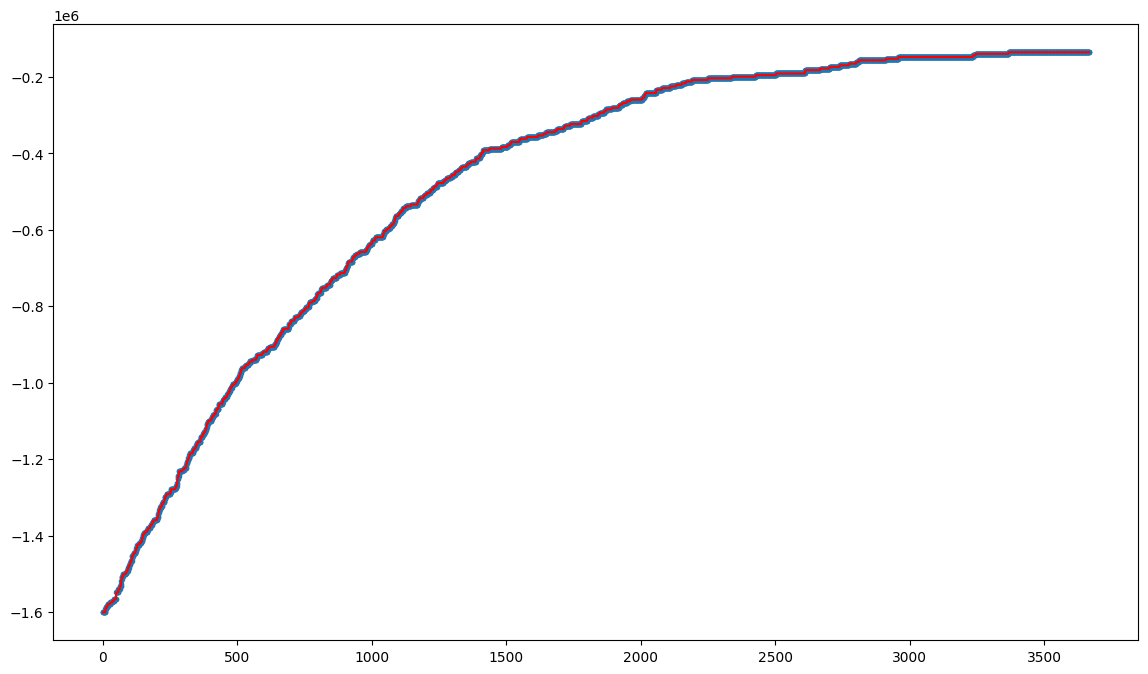

In [2324]:
# PLOT the final solution
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")